In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorboard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input

from tensorflow.keras.metrics import Precision, Accuracy
from tensorflow.keras.metrics import SensitivityAtSpecificity, SpecificityAtSensitivity
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from tensorflow.keras.models import Model

In [3]:
img_width, img_height = 224, 224
# Set up the data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Dataset_Clean/Covid_vs_Normal_Final/train', 
                                                    target_size=(img_width, img_height), batch_size=32, 
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/Dataset_Clean/Covid_vs_Normal_Final/val', 
                                                  target_size=(img_width, img_height), batch_size=32, 
                                                  class_mode='categorical')

Found 2737 images belonging to 2 classes.
Found 937 images belonging to 2 classes.


In [4]:
train_generator.class_indices

{'Covid': 0, 'Normal': 1}

In [5]:
# Define the Keras TensorBoard callback.
logdir = "/content/drive/MyDrive/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# To save the training history
csv_logger = CSVLogger("/content/drive/MyDrive/Trainig_History.csv", append=True)

In [6]:
checkpoint_filepath = "/content/drive/MyDrive/CheXNet_Covid_Normal.h5"
SAVE_BEST_ONLY = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=0, 
                                 save_best_only=True, mode='auto')

CALLBACKS = [tensorboard_callback, csv_logger, SAVE_BEST_ONLY]

In [7]:
from tensorflow.keras.applications import DenseNet121

image_shape= (224,224,3)
image_input= Input(shape=(224,224,3))
base=DenseNet121(include_top=False,input_tensor=image_input,input_shape=image_shape,pooling="avg")
pred=Dense(14,"sigmoid")(base.output)

chexnet_model=Model(inputs=base.input,outputs=pred)
# Load the pre-trained weights
chexnet_model.load_weights("/content/drive/MyDrive/Paper_Codes/CheXNet_Keras_0.3.0_weights.h5")

29084464/29084464 [==============================] - 0s 0us/step


In [9]:
# Remove last 2 layers
final_chexnet_model=Model(inputs=chexnet_model.inputs,outputs=chexnet_model.layers[-2].output,name="Chexnet_model")
new_model = Sequential()
new_model.add(final_chexnet_model)
new_model.add(Dense(2,activation='softmax'))

# Compile the model
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'TruePositives',
                                                                          'TrueNegatives', 'FalsePositives', 'FalseNegatives', 
                                                                          tf.keras.metrics.SpecificityAtSensitivity(0.5), 
                                                                          tf.keras.metrics.SensitivityAtSpecificity(0.5)])
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Chexnet_model (Functional)  (None, 1024)              7037504   
                                                                 
 dense_2 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 7,039,554
Trainable params: 6,955,906
Non-trainable params: 83,648
_________________________________________________________________


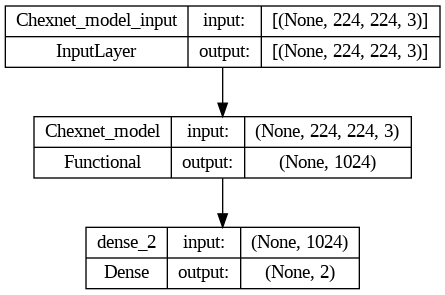

In [10]:
tf.keras.utils.plot_model(new_model,show_shapes=True,show_layer_names=True,to_file="chex.png") 

In [11]:
history = new_model.fit(train_generator, epochs=50, validation_data=test_generator, callbacks=CALLBACKS)

Epoch 1/50
86/86 [==============================] - 871s 9s/step - loss: 0.0798 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - true_positives: 2698.0000 - true_negatives: 2698.0000 - false_positives: 39.0000 - false_negatives: 39.0000 - specificity_at_sensitivity_1: 0.9923 - sensitivity_at_specificity_1: 0.9923 - val_loss: 0.1748 - val_accuracy: 0.9658 - val_precision: 0.9658 - val_recall: 0.9658 - val_true_positives: 905.0000 - val_true_negatives: 905.0000 - val_false_positives: 32.0000 - val_false_negatives: 32.0000 - val_specificity_at_sensitivity_1: 0.9658 - val_sensitivity_at_specificity_1: 0.9658
Epoch 2/50
86/86 [==============================] - 51s 589ms/step - loss: 0.0376 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - true_positives: 2714.0000 - true_negatives: 2714.0000 - false_positives: 23.0000 - false_negatives: 23.0000 - specificity_at_sensitivity_1: 0.9931 - sensitivity_at_specificity_1: 0.9931 - val_loss: 0.1799 - val_accuracy: 0.9658 - val_preci

In [12]:
# Evaluate the model
loss, accuracy,*_ = new_model.evaluate(test_generator)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

30/30 [==============================] - 5s 154ms/step - loss: 0.1659 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - true_positives: 914.0000 - true_negatives: 914.0000 - false_positives: 23.0000 - false_negatives: 23.0000 - specificity_at_sensitivity_1: 0.9797 - sensitivity_at_specificity_1: 0.9797
Test Loss: 0.16586677730083466
Test Accuracy: 0.9754535555839539


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = new_model.predict_generator(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred_classes)


sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
